## 0. Setup

In [34]:
# Importing Libraries

import re
import string
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import unicodedata
from gensim.models import Word2Vec
from keras import layers, metrics, optimizers, losses
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

plt.style.use('seaborn-bright')

## 1. Exploring the data

In [35]:
training = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [36]:
# Training set preview
training.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [37]:
# Test set preview
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [38]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Breakdown of the columns in the training dataset:
- id: A unique identifier for each training.
- keyword: A particular keyword from the training (can be blank).
- location: The location the training was sent from (can be blank).
- text: The text of the training.
- target: `1` indicates that the training is about a real disaster, `0` that it is not.

#### Exploring the dimensions of the datasets

In [39]:
print('there are {} rows and {} columns in test.csv'.format(test.shape[0], test.shape[1]))
print('there are {} rows and {} columns in training.csv'.format(training.shape[0], training.shape[1]))

there are 3263 rows and 4 columns in test.csv
there are 7613 rows and 5 columns in training.csv


#### Visualizing the target classes

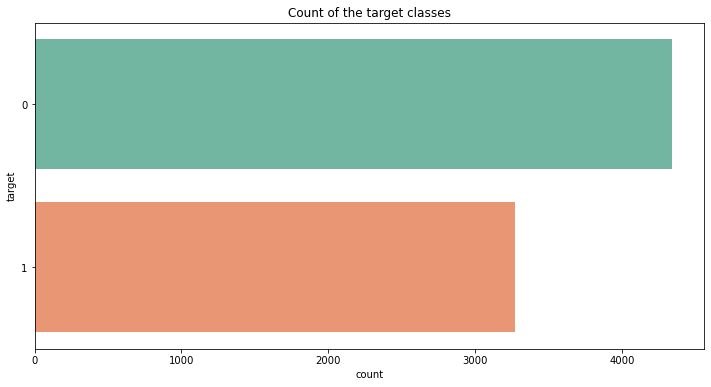

In [40]:
plt.figure(figsize=(12, 6))
plt.title("Count of the target classes")
sns.countplot(y=training["target"], linewidth=1, palette='Set2')
plt.show()

*There are around 3200 samples of tweets about real disasters and about 4500 non-disaster tweets.*

#### Analyzing the length of the tweets

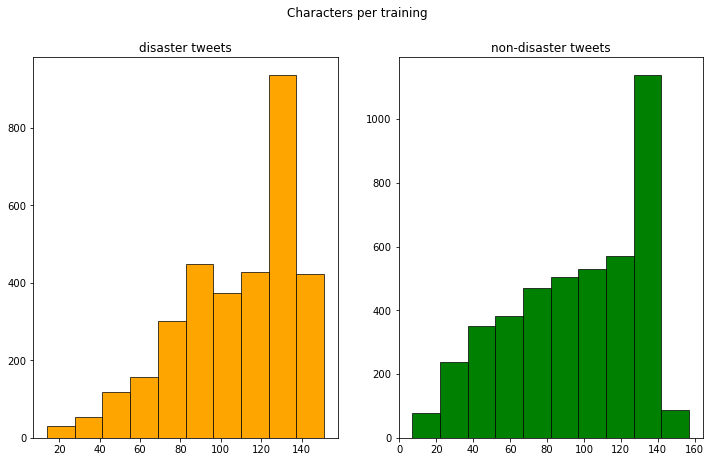

In [41]:
disaster_tweets = training[training['target'] == 1]['text'].str
non_disaster_tweets = training[training['target'] == 0]['text'].str

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

char_len_dis = disaster_tweets.len()
ax1.hist(char_len_dis, color='orange', edgecolor='black', linewidth=0.7)
ax1.set_title('disaster tweets')

char_len_ndis = non_disaster_tweets.len()
ax2.hist(char_len_ndis, color='green', edgecolor='black', linewidth=0.7)
ax2.set_title('non-disaster tweets')

plt.suptitle("Characters per training")
plt.show()

*The characters count of disaster and non-disaster tweets are between 120 and 140.*

#### Analyzing the number of words in the tweets

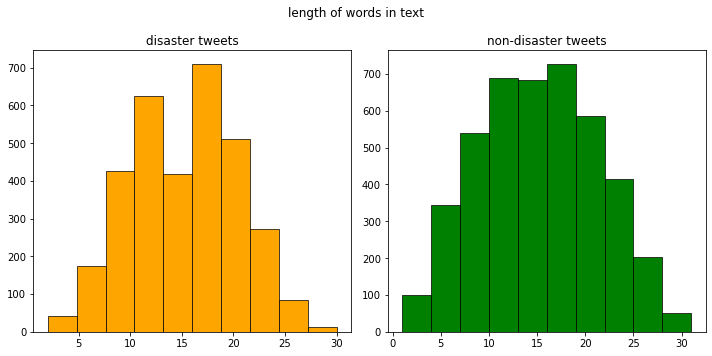

In [42]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

char_len_dis = disaster_tweets.split().map(lambda x: len(x))
ax1.hist(char_len_dis, color='orange', edgecolor='black', linewidth=0.7)
ax1.set_title('disaster tweets')

char_len_ndis = non_disaster_tweets.split().map(lambda x: len(x))
ax2.hist(char_len_ndis, color='green', edgecolor='black', linewidth=0.7)
ax2.set_title('non-disaster tweets')

plt.suptitle("length of words in text")
plt.tight_layout()
plt.show()

*The number of words in disaster and non-disaster tweets are in the range 15 - 20.*

#### Analysis of the average length of words in each tweet

C:\Users\todor\anaconda3\envs\disaster_tweets\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\todor\anaconda3\envs\disaster_tweets\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


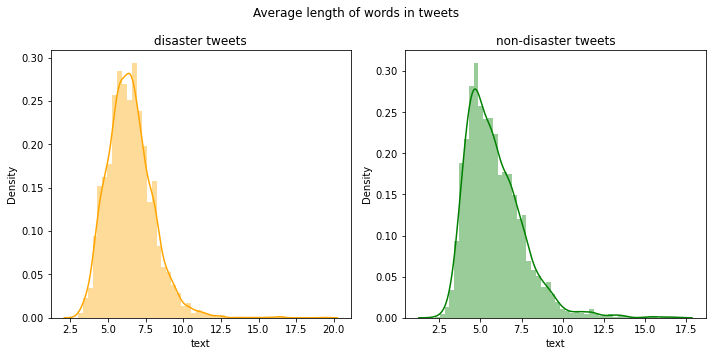

In [43]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

char_len_dis = disaster_tweets.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_dis.map(lambda x: np.mean(x)), ax=ax1, color='orange')
ax1.set_title('disaster tweets')

char_len_ndis = non_disaster_tweets.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_ndis.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('non-disaster tweets')

plt.suptitle("Average length of words in tweets")
plt.tight_layout()
plt.show()

*The average word count for disaster tweets is in the range 7 - 7.5, while for non-disaster tweets in the range of 4.5 - 5.*

In [44]:
# Creating a corpus for further analysis.
def create_corpus(target):
    corpus = []
    for x in training[training['target'] == target]['text'].str.split():
        corpus.extend(x)
    return corpus

#### Analysing the top stop words in text.

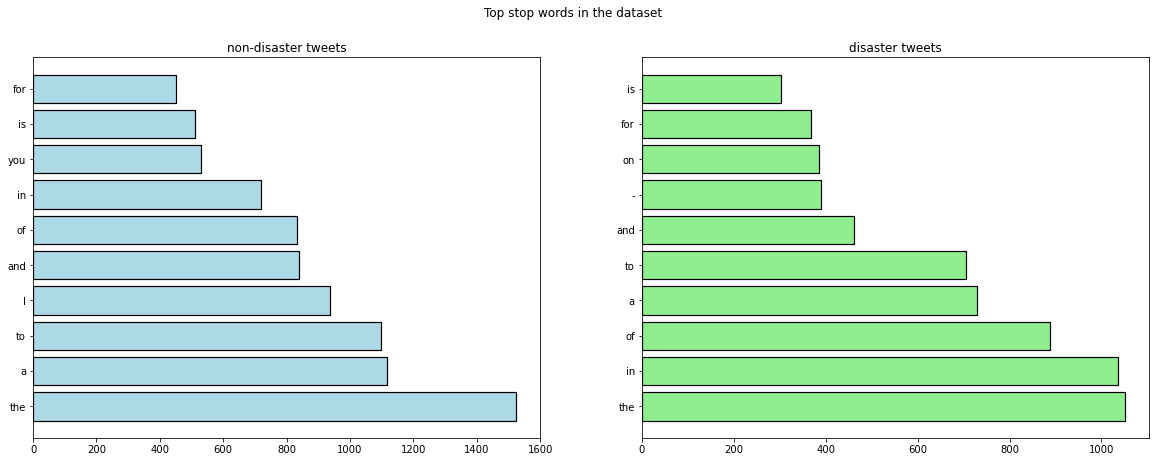

In [45]:
def analyse_stopwords(func, target):
    values_list = []
    for labels in range(0, len(target)):
        dic = defaultdict(int)
        corpus = func(target[labels])
        for word in corpus:
            dic[word] += 1
        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
        x_items, y_values = zip(*top)
        values_list.append(x_items)
        values_list.append(y_values)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    ax1.barh(values_list[0], values_list[1], color="lightblue", edgecolor='black', linewidth=1.2)
    ax1.set_title("non-disaster tweets")

    ax2.barh(values_list[2], values_list[3], color="lightgreen", edgecolor='black', linewidth=1.2)
    ax2.set_title("disaster tweets")

    plt.suptitle("Top stop words in the dataset")
    plt.show()


analyse_stopwords(create_corpus, [0, 1])

*From the bar chart we can observe that the most frequently occurring stopwords in both disaster/non-disaster tweets is "the" (1000+ occurrences) while the least occurring for non-disaster is "for" (400+ occurrences) and for disaster tweets is "is" (300+ occurrences).*

#### Analysing punctuation

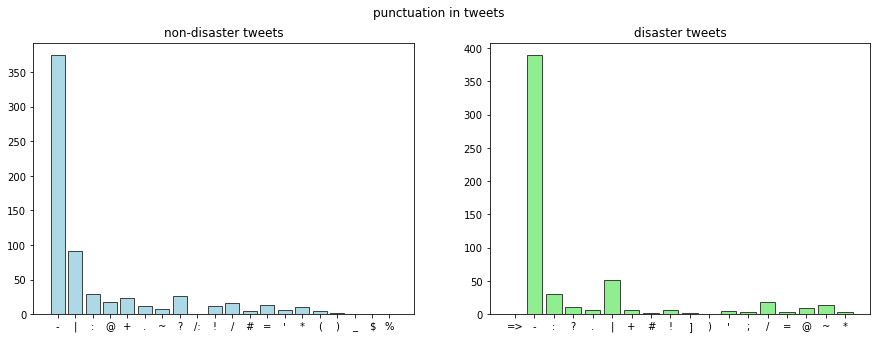

In [46]:
def analyse_punctuation(func, target):
    values_list = []
    special = string.punctuation
    for labels in range(0, len(target)):
        dic = defaultdict(int)
        corpus = func(target[labels])
        for i in corpus:
            if i in special:
                dic[i] += 1
        x_items, y_values = zip(*dic.items())
        values_list.append(x_items)
        values_list.append(y_values)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.bar(values_list[0], values_list[1], color="lightblue", edgecolor='black', linewidth=0.7)
    ax1.set_title("non-disaster tweets")

    ax2.bar(values_list[2], values_list[3], color="lightgreen", edgecolor='black', linewidth=0.7)
    ax2.set_title("disaster tweets")

    plt.suptitle("punctuation in tweets")
    plt.show()


analyse_punctuation(create_corpus, [0, 1])

*From the bar chart we can see that the punctuation with the most occurrences in both disaster/non-disaster tweets is "-" (350+) while the ones with the least occurrences for non-disaster are "%", ":", "$", "_" and for disaster tweets they are "=>" and ")".*

#### Null values analysis

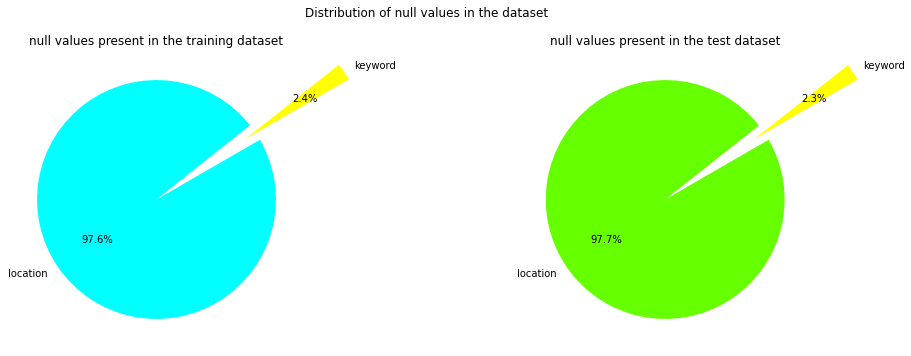

In [47]:
missing_train = training.isnull().sum()
missing_test = test.isnull().sum()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
missing_train = missing_train[missing_train > 0].sort_values()
ax1.pie(missing_train, autopct='%1.1f%%', startangle=30, explode=[0.9, 0], labels=["keyword", "location"],
        colors=['yellow', 'cyan'])
ax1.set_title("null values present in the training dataset")

missing_test = missing_test[missing_test > 0].sort_values()
ax2.pie(missing_test, autopct='%1.1f%%', startangle=30, explode=[0.9, 0], labels=["keyword", "location"],
        colors=['yellow', '#66ff00'])
ax2.set_title("null values present in the test dataset")

plt.suptitle("Distribution of null values in the dataset")
plt.tight_layout()
plt.show()

*The above pictorial representation displays the missing values in each of the datasets. From the distribution, it is observed that columns `keyword` and `location` contain missing values. For the training data, the % of missing values is 97.6 for `location` and 24 for `keyword`, while for the testing dataset, it is 97.7% for `location` and 23% for `keyword`. Also, the column having maximum missing values is: `location` while `keyword` column has the minimum count of missing values for both sets of data.*

#### Analysing the top 20 disastrous keywords

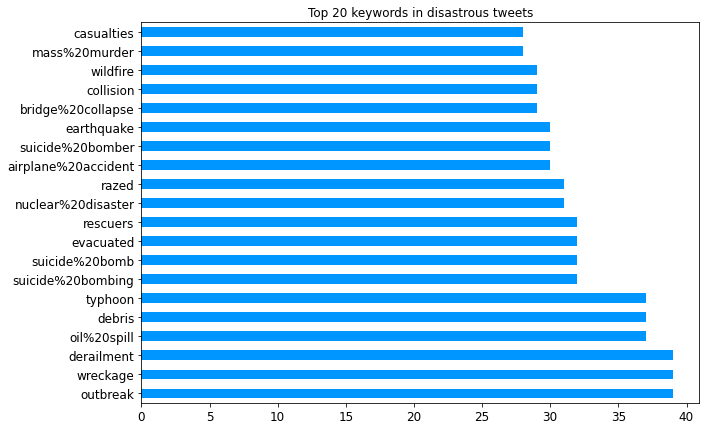

In [48]:
plt.figure(figsize=(10, 7))
training[training['target'] == 1]['keyword'].value_counts()[:20].plot(kind='barh', fontsize=12, color='#0096FF',
                                                                      linewidth=0.7,
                                                                      title='Top 20 keywords in disastrous tweets')
plt.show()

*From the above bar chart is evident that `outbrak`, `wreckage` and `derailment` are the most frequent keywords in disastrous tweets with close to 40 occurrences.*

#### Analysing the top 20 disastrous locations

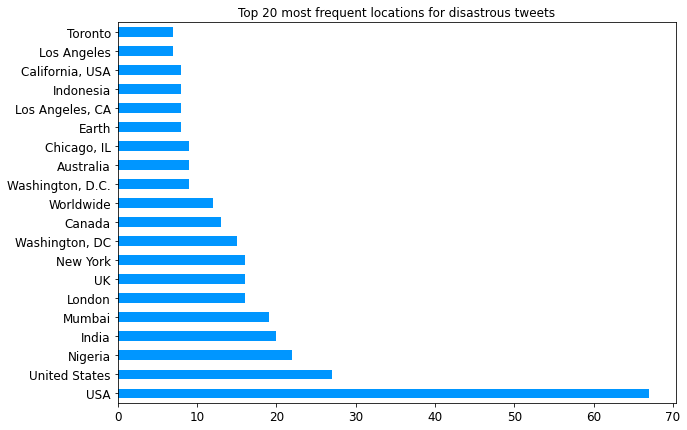

In [49]:
plt.figure(figsize=(10, 7))
training[training["target"] == 1]["location"].value_counts()[:20].plot(kind='barh', fontsize=12, color='#0096FF',
                                                                       linewidth=0.7,
                                                                       title='Top 20 most frequent locations for disastrous tweets')
plt.show()

*From the above bar chart we can see that, from the tweets that do have a location, the United States is the most frequent.*

## 2. Cleaning up the data

There are some words/characters that need to be removed and formatted:
- Remove all URL's.
- Remove all Emoji's.
- Remove all HTMl tags.
- Lowercase all text.
- Words shorter than 2 symbols.

#### Cleaning up the text

In [50]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.update(string.punctuation)


def cleanup_text(texts):
    corpus = list()
    for text in texts:

        # remove non-ascii characters
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

        # remove html tags
        text = re.sub(r'<.*?>', ' ', text)

        # remove urls
        text = re.sub(r'https?://\S+|www\.\S+|http?://\S+', ' ', text)

        # remove emojis
        text = re.sub(u"\U0001F600-\U0001F64F", ' ', text)

        # remove symbols
        text = re.sub(u"\U0001F300-\U0001F5FF", ' ', text)

        # keeping only alphabetic characters
        text = re.sub(r'[^a-zA-Z]', ' ', text)

        text = text.lower()
        text = text.split()

        # remove all words, shorter than 2 characters
        text = [i for i in text if len(i) > 2]

        # remove stopwords from text
        final_text = []
        for word in text:
            word = word.strip()
            if word not in stop_words:
                final_text.append(word)

        text = " ".join(final_text)

        text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
        text = " ".join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])

        corpus.append(text)

    return corpus


training['clean_text'] = cleanup_text(training['text'])
test['clean_text'] = cleanup_text(test['text'])
training.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...


*We can observe the effect of the cleanup and how the algorithm leaves only the important words from the training*

In [51]:
sample_df = training.sample(n=10).reset_index(drop=True)
for i in range(5):
    print("-" * 100)
    print(f"BEFORE: {sample_df.loc[i, 'text']}\n")
    print(f"AFTER: {sample_df.loc[i, 'clean_text']}")

----------------------------------------------------------------------------------------------------
BEFORE: //im gonna beat armageddon as Hsu Hao ????
just got a flawless on my first try

AFTER: gonna beat armageddon hsu hao get flawless first try
----------------------------------------------------------------------------------------------------
BEFORE: Michael talking about when he was electrocuted omg #ROWYSOLouisville http://t.co/HxVfmoUhDM

AFTER: michael talk electrocute omg rowysolouisville
----------------------------------------------------------------------------------------------------
BEFORE: @OllyMursAus I do feel sorry for him! He is not a piece of meat! He is a nice guy... People don't need to rush him and screams in his face!

AFTER: ollymursaus feel sorry piece meat nice guy people need rush scream face
----------------------------------------------------------------------------------------------------
BEFORE: @KerryKatona7 hello wud u kindly consider following me bak

#### Analyse the top 20 words in the training data

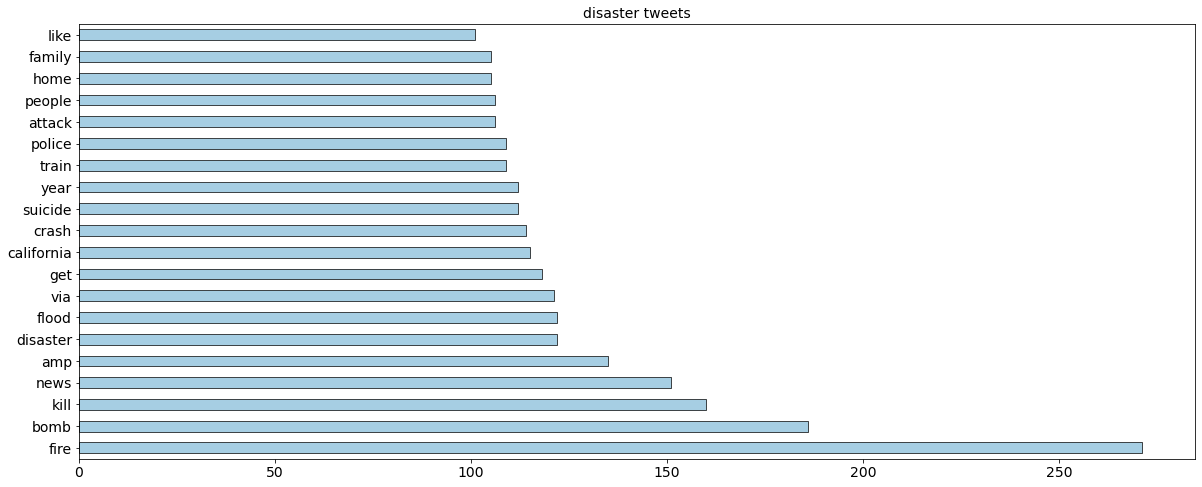

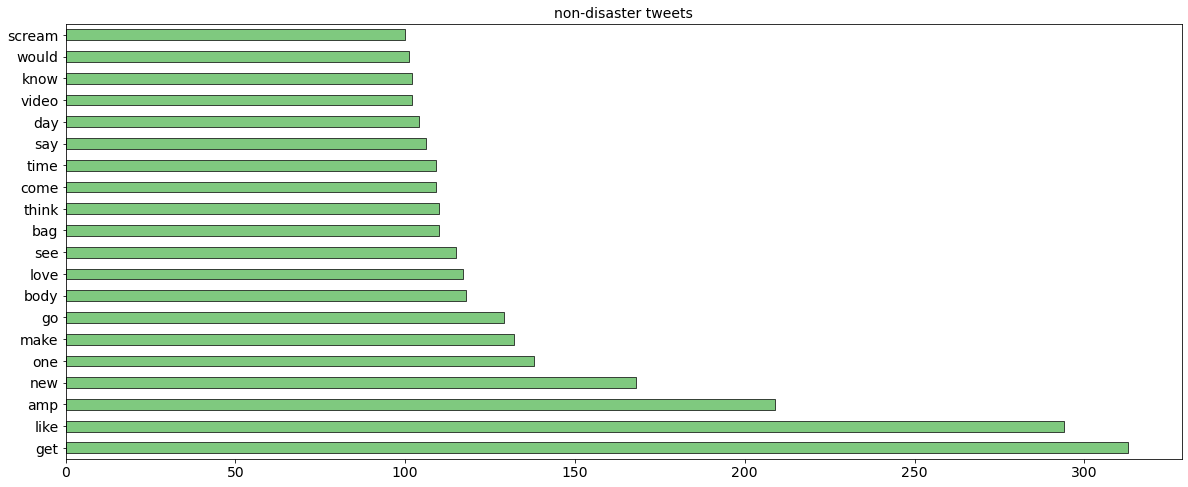

In [52]:
disaster_tweet_clean = training[training.target == 1]["clean_text"]
non_disaster_tweet_clean = training[training.target == 0]["clean_text"]

color = ['Paired', 'Accent']
dataSplit = [disaster_tweet_clean, non_disaster_tweet_clean]
title = ["disaster tweets", "non-disaster tweets"]
for item in range(2):
    plt.figure(figsize=(20, 8))
    plt.title(title[item], fontsize=14)
    pd.Series(' '.join([i for i in dataSplit[item]]).split()).value_counts().head(20).plot(kind='barh', fontsize=14,
                                                                                           colormap=color[item],
                                                                                           edgecolor='black',
                                                                                           linewidth=0.7)
    plt.show()

*`fire` seems to be the most frequent word among the disaster tweets (+270), while `like` is the most frequent for the non-disaster tweets (+260). Other frequent words in the disaster tweets are `news`, `amp`, and `disaster`. For the non-disaster tweets `amp`, `get`, and `new` are also frequent.*

From the above graphs we see that, although we cleaned the data, there are still some unnecessary words, such as `like`, `amp`, `get`. We will now remove them.

In [53]:
common_words = ['via', 'like', 'build', 'get', 'would', 'one', 'two', 'feel', 'lol', 'fuck', 'take', 'way', 'may',
                'first', 'latest', 'want', 'make', 'back', 'see', 'know', 'let', 'look', 'come', 'got', 'still', 'say',
                'think', 'great', 'pleas', 'amp']


def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)


training["clean_text"] = training["clean_text"].apply(text_cleaning)
test["clean_text"] = test["clean_text"].apply(text_cleaning)

Let's review the data now

### Top 20 words in the training data (after a thorough cleanup)

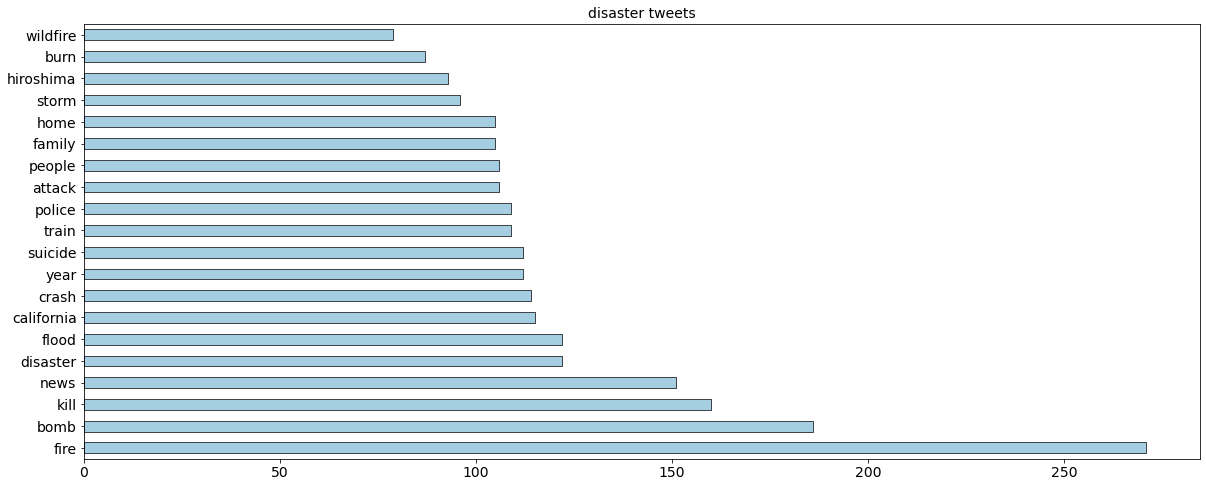

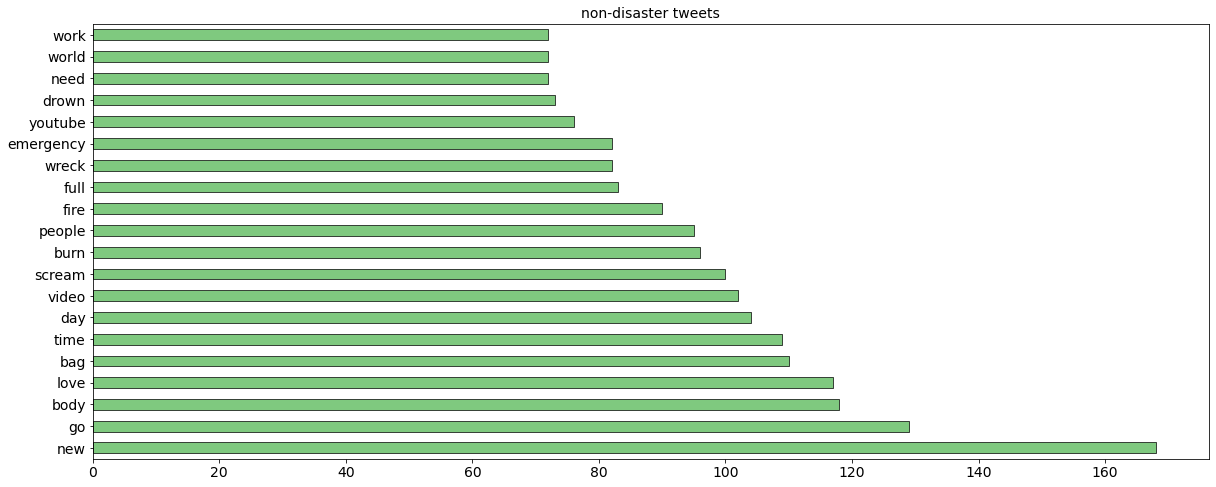

In [54]:
disaster_tweet_clean = training[training.target == 1]["clean_text"]
non_disaster_tweet_clean = training[training.target == 0]["clean_text"]

color = ['Paired', 'Accent']
dataSplit = [disaster_tweet_clean, non_disaster_tweet_clean]
title = ["disaster tweets", "non-disaster tweets"]
for item in range(2):
    plt.figure(figsize=(20, 8))
    plt.title(title[item], fontsize=14)
    pd.Series(' '.join([i for i in dataSplit[item]]).split()).value_counts().head(20).plot(kind='barh', fontsize=14,
                                                                                           colormap=color[item],
                                                                                           edgecolor='black',
                                                                                           linewidth=0.7)
    plt.show()

*After the cleanup, some the most frequent words in the disaster tweets dataset are `fire`, `news`, `disaster`, `california`, `suicide`. From the non-disaster tweets, the most frequent are: `new`, `body`, `time`, `day`.*

#### Plotting Common N-grams

In [55]:
def top_n_grams(data, top_grams_num, grams):
    word_freq = []
    if grams == 2:
        count_vec = CountVectorizer(ngram_range=(2, 2)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    elif grams == 3:
        count_vec = CountVectorizer(ngram_range=(3, 3)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

    return word_freq[:top_grams_num]

##### Bigrams

<ipython-input-56-a97d9e46e77d>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rotation=90, labels=disaster_bigrams_df["word"], fontsize=14)
<ipython-input-56-a97d9e46e77d>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(rotation=90, labels=non_disaster_bigrams_df["word"], fontsize=14)


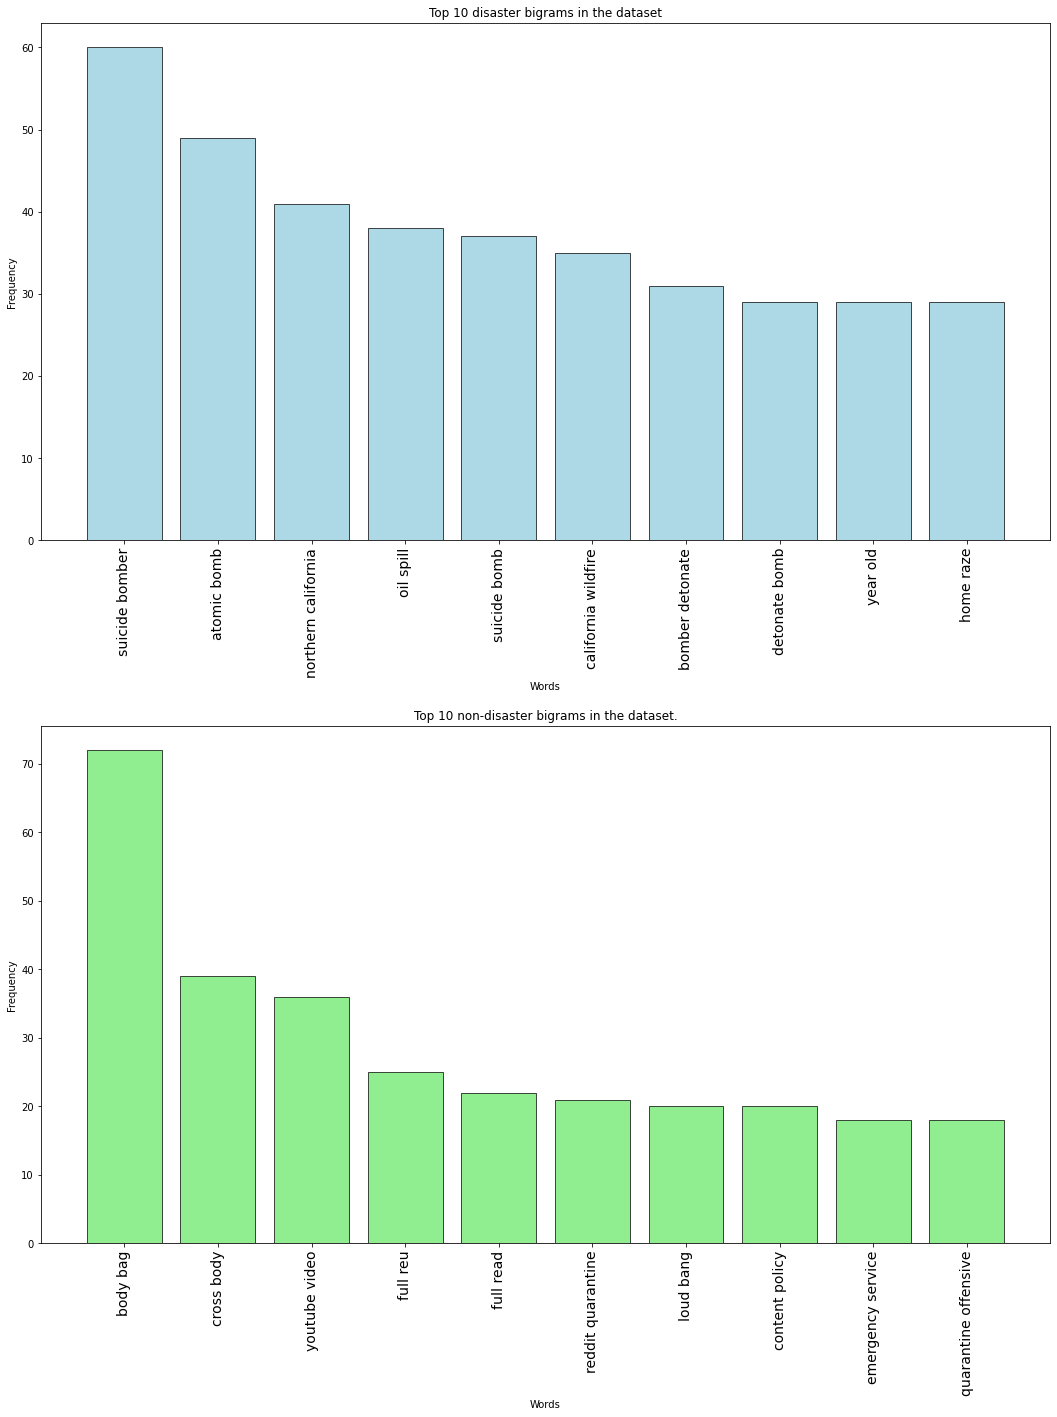

In [56]:
disaster_bigrams = top_n_grams(training[training['target'] == 1]["clean_text"], 10, 2)
non_disaster_bigrams = top_n_grams(training[training['target'] == 0]["clean_text"], 10, 2)

disaster_bigrams_df = pd.DataFrame(disaster_bigrams, columns=['word', 'freq'])
non_disaster_bigrams_df = pd.DataFrame(non_disaster_bigrams, columns=['word', 'freq'])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

ax1.bar(disaster_bigrams_df["word"], disaster_bigrams_df["freq"], color="lightblue", edgecolor='black', linewidth=0.7)
ax1.set_title("Top 10 disaster bigrams in the dataset")
ax1.set_xlabel("Words")
ax1.set_ylabel("Frequency")
ax1.set_xticklabels(rotation=90, labels=disaster_bigrams_df["word"], fontsize=14)

ax2.bar(non_disaster_bigrams_df["word"], non_disaster_bigrams_df["freq"], color="lightgreen", edgecolor='black',
        linewidth=0.7)
ax2.set_title("Top 10 non-disaster bigrams in the dataset.")
ax2.set_xlabel("Words")
ax2.set_ylabel("Frequency")
ax2.set_xticklabels(rotation=90, labels=non_disaster_bigrams_df["word"], fontsize=14)
plt.tight_layout(pad=1.85)
plt.show()

*`suicide bomber`, `northern california`, and `oil spill` are among the most frequent bigrams in the disaster tweets dataset, while `liked youtube`, `cross body`, and `youtube video` are among the most common bigrams in the non-disaster dataset.*

##### Trigrams

<ipython-input-57-b155669fd281>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rotation=90, labels=disaster_trigrams_df["word"], fontsize=14)
<ipython-input-57-b155669fd281>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(rotation=90, labels=non_disaster_trigrams_df["word"], fontsize=14)


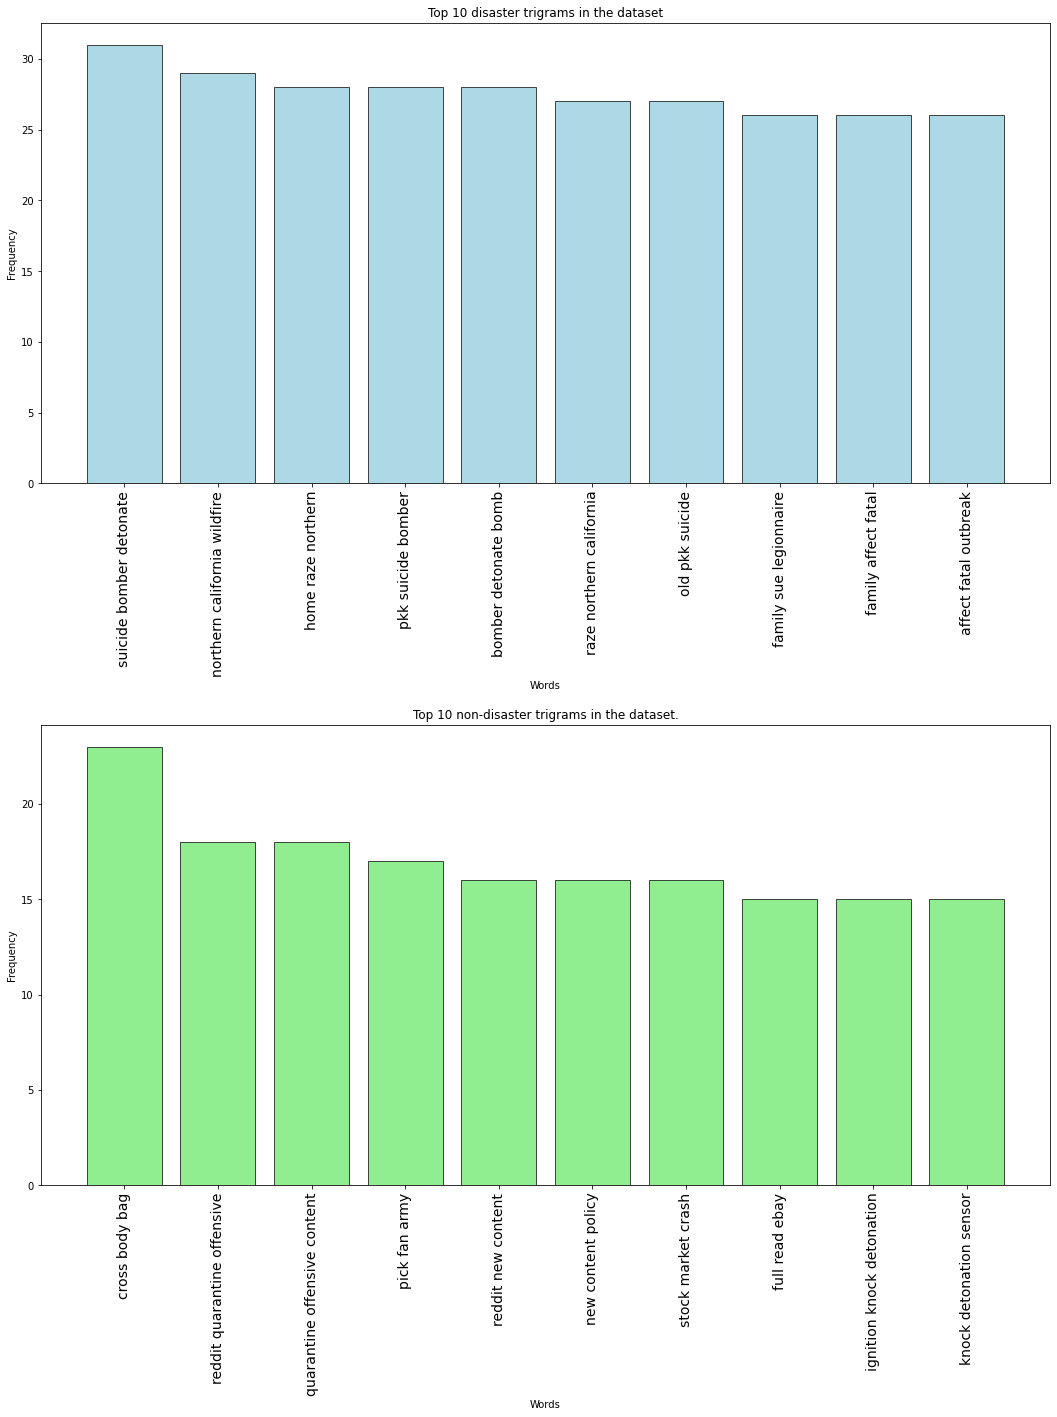

In [57]:
disaster_trigrams = top_n_grams(training[training['target'] == 1]["clean_text"], 10, 3)
non_disaster_trigrams = top_n_grams(training[training['target'] == 0]["clean_text"], 10, 3)

disaster_trigrams_df = pd.DataFrame(disaster_trigrams, columns=['word', 'freq'])
non_disaster_trigrams_df = pd.DataFrame(non_disaster_trigrams, columns=['word', 'freq'])
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

ax1.bar(disaster_trigrams_df["word"], disaster_trigrams_df["freq"], color="lightblue", edgecolor='black', linewidth=0.7)
ax1.set_title("Top 10 disaster trigrams in the dataset")
ax1.set_xlabel("Words")
ax1.set_ylabel("Frequency")
ax1.set_xticklabels(rotation=90, labels=disaster_trigrams_df["word"], fontsize=14)

ax2.bar(non_disaster_trigrams_df["word"], non_disaster_trigrams_df["freq"], color="lightgreen", edgecolor='black',
        linewidth=0.7)
ax2.set_title("Top 10 non-disaster trigrams in the dataset.")
ax2.set_xlabel("Words")
ax2.set_ylabel("Frequency")
ax2.set_xticklabels(rotation=90, labels=non_disaster_trigrams_df["word"], fontsize=14)
plt.tight_layout(pad=1.85)
plt.show()

*When it comes to trigrams, `suicide bomber detonated`, and `northern california wildfire` are among the most frequent ones in the disaster tweets dataset, while `liked youtube video`, `cross body bag`, and `reddit quarantine offensive` are among the most common in the non-disaster dataset.*

#### Visualize all words using WordCloud

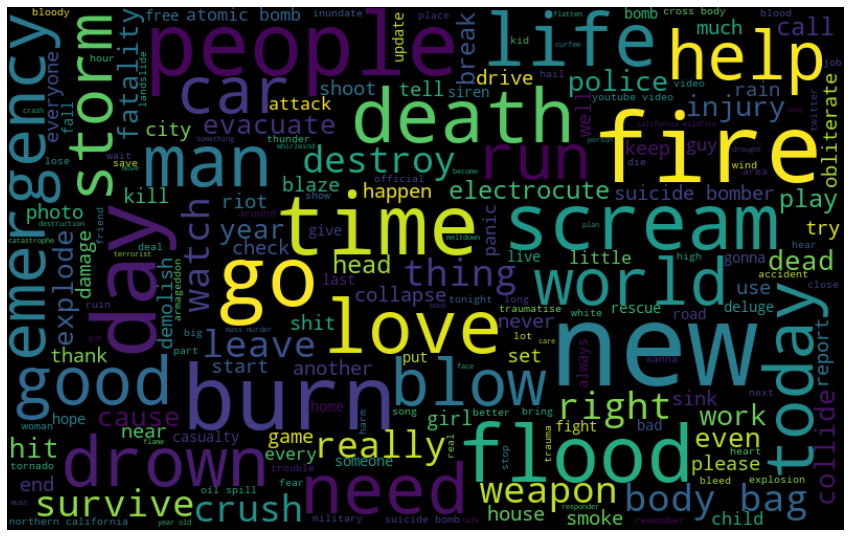

In [58]:
all_word = ' '.join([text for text in training['clean_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Visualize all words that signify disaster using WordCloud

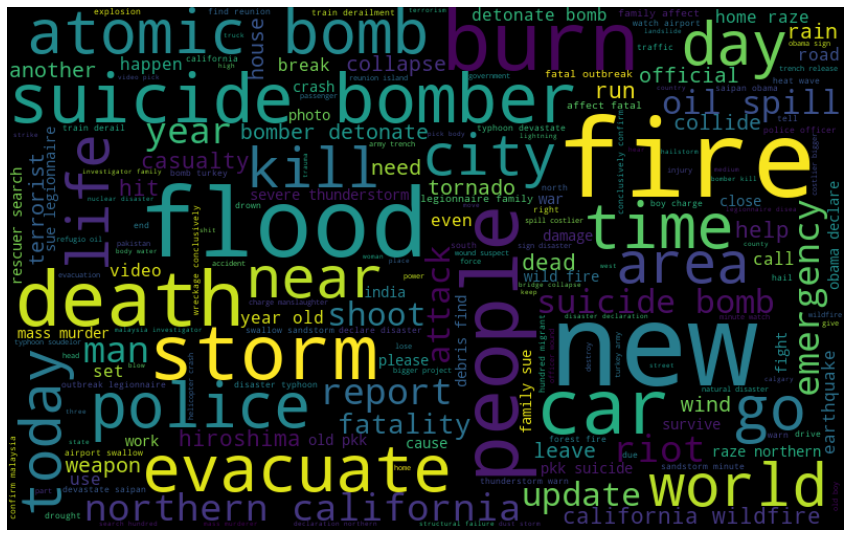

In [59]:
normal_words = ' '.join([text for text in training['clean_text'][training['target'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 3. Preparing the data
### Word embedding

#### Tokenizing with Word2Vec

In [60]:
training['tokenized_text'] = training['clean_text'].apply(lambda x: word_tokenize(x))
test['tokenized_text'] = test['clean_text'].apply(lambda x: word_tokenize(x))

In [61]:
corpus = list(training['tokenized_text']) + list(test['tokenized_text'])

We will use the gensim Word2Vec for embedding the tokens.

In [62]:
wv_model = Word2Vec(corpus, vector_size=150, window=3, min_count=2)
wv_model.train(corpus, total_examples=len(corpus), epochs=10)  # training for 10 epochs

(784604, 899500)

In [63]:
vector_list = wv_model.wv.key_to_index


def word_embedding(token_list):
    if len(token_list) < 1:
        return np.random.rand(150)
    else:
        vectorized = [wv_model.wv[word] if word in vector_list else np.random.rand(150) for word in token_list]

    sum_vec = np.sum(vectorized, axis=0)
    return sum_vec / len(vectorized)

In [64]:
embedding_train = training['tokenized_text'].apply(lambda x: word_embedding(x))
embedding_test = test['tokenized_text'].apply(lambda x: word_embedding(x))

embedding_train = np.array([x for x in embedding_train])
embedding_test = np.array([x for x in embedding_test])

In [65]:
X_train, X_val, y_train, y_val = train_test_split(embedding_train, training['target'], test_size=0.2,
                                                  random_state=42)

In [66]:
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)

RandomForestClassifier()

In [67]:
pred = model1.predict(X_val)
print(f"The accuracy score is {accuracy_score(y_val, pred) * 100}")

The accuracy score is 75.04924491135915


*We get an accuracy of 75%.*

#### Text Encoding with Keras Tokenized

In [68]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='UNK')
tokenizer.fit_on_texts(list(training['clean_text']) + list(test['text']))

In [69]:
X_train_ohe = tokenizer.texts_to_matrix(training['clean_text'], mode='binary')
X_test_ohe = tokenizer.texts_to_matrix(test['text'], mode='binary')
y_train = np.array(training['target']).astype(int)

print(f"X_train shape: {X_train_ohe.shape}")
print(f"X_test shape: {X_test_ohe.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (7613, 1000)
X_test shape: (3263, 1000)
y_train shape: (7613,)


### Modeling on a neural network

#### Train validation split

In [70]:
X_train_ohe, X_val_ohe, y_train, y_val = train_test_split(X_train_ohe, y_train, random_state=42, test_size=0.2)

print(f"X_train shape: {X_train_ohe.shape}")
print(f"X_val shape: {X_val_ohe.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (6090, 1000)
X_val shape: (1523, 1000)
y_train shape: (6090,)
y_val shape: (1523,)


#### Setting up the model

In [71]:

def setup_model():
    model = Sequential()
    model.add(layers.Dense(1, activation='sigmoid', input_shape=(vocab_size,)))

    model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss=losses.binary_crossentropy,
                  metrics=[metrics.binary_accuracy])

    return model


model = setup_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1001      
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model.fit(X_train_ohe, y_train, epochs=20, batch_size=512, validation_data=(X_val_ohe, y_val))

Epoch 1/20
12/12 [==============================] - 0s 24ms/step - loss: 0.6853 - binary_accuracy: 0.5634 - val_loss: 0.6785 - val_binary_accuracy: 0.6297
Epoch 2/20
12/12 [==============================] - 0s 4ms/step - loss: 0.6739 - binary_accuracy: 0.6514 - val_loss: 0.6701 - val_binary_accuracy: 0.6815
Epoch 3/20
12/12 [==============================] - 0s 5ms/step - loss: 0.6650 - binary_accuracy: 0.6970 - val_loss: 0.6624 - val_binary_accuracy: 0.7104
Epoch 4/20
12/12 [==============================] - 0s 4ms/step - loss: 0.6569 - binary_accuracy: 0.7248 - val_loss: 0.6553 - val_binary_accuracy: 0.7229
Epoch 5/20
12/12 [==============================] - 0s 5ms/step - loss: 0.6491 - binary_accuracy: 0.7388 - val_loss: 0.6485 - val_binary_accuracy: 0.7347
Epoch 6/20
12/12 [==============================] 

In [73]:
_, accuracy = model.evaluate(X_val_ohe, y_val)

48/48 [==============================] - 0s 1ms/step - loss: 0.5743 - binary_accuracy: 0.7623


*We get an accuracy of 76%.*